In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr

import metpy.constants

from sublimpy import tidy

from math import pi
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import altair as alt
alt.data_transformers.enable('json')

import glob
import pytz
from sublimpy import utils

import matplotlib.pyplot as plt

# User inputs

In [ ]:
start_date = '20221130'
# end_date = '20230509'
end_date = '20230517'

start_date_lastseason = '20211101'
end_date_lastseason = '20220601'

tidy_dataset_fn = f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_dataset_5min_fn = f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_daily_dataset_output_fn = f"tidy_df_daily_{start_date}_{end_date}_noplanar_fit.parquet"

# Load data

## SoS Measurements

This dataset is created by the `create_turbulence_dataset.ipynb` notebook

In [4]:
try:
    tidy_df_30Min = pd.read_parquet(
        tidy_dataset_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

try:
    tidy_df_5Min = pd.read_parquet(
        tidy_dataset_5min_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

In [5]:
src = tidy_df_30Min[tidy_df_30Min.variable == "counts_3m_c_1"]
src['percent good data'] = src['value'] / 6000

times_with_75percent_dropped = src[src['percent good data'] > 0.25].time
times_with_50percent_dropped = src[src['percent good data'] > 0.50].time
times_with_25percent_dropped = src[src['percent good data'] > 0.75].time
times_with_15percent_dropped = src[src['percent good data'] > 0.85].time
times_with_10percent_dropped = src[src['percent good data'] > 0.90].time
times_with_5percent_dropped = src[src['percent good data'] > 0.95].time
times_with_1percent_dropped = src[src['percent good data'] > 0.99].time

src = tidy_df_30Min[tidy_df_30Min.variable == "w_h2o__3m_c"]
print((src[src.time.isin(times_with_75percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_50percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_25percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_15percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_10percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_5percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_1percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])

/tmp/ipykernel_496/3119507157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['percent good data'] = src['value'] / 6000


34.27204042543722
34.21665411485331
33.855695271057954
33.613891428377336
39.33905738953564
38.68476299745868
33.68206187117426


In [6]:
src = tidy_df_30Min[tidy_df_30Min.variable == "counts_3m_d_1"]
src['percent good data'] = src['value'] / 6000

times_with_75percent_dropped = src[src['percent good data'] > 0.25].time
times_with_50percent_dropped = src[src['percent good data'] > 0.50].time
times_with_25percent_dropped = src[src['percent good data'] > 0.75].time
times_with_15percent_dropped = src[src['percent good data'] > 0.85].time
times_with_10percent_dropped = src[src['percent good data'] > 0.90].time
times_with_5percent_dropped = src[src['percent good data'] > 0.95].time
times_with_1percent_dropped = src[src['percent good data'] > 0.99].time

src = tidy_df_30Min[tidy_df_30Min.variable == "w_h2o__3m_d"]
print((src[src.time.isin(times_with_75percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_50percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_25percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_15percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_10percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_5percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])
print((src[src.time.isin(times_with_1percent_dropped)]['value'].cumsum()*60*30/999.97495).iloc[-1])

/tmp/ipykernel_496/2893927094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['percent good data'] = src['value'] / 6000


36.35878357673768
35.75030557224347
34.965016739916635
34.663610282324534
34.371173608645584
33.67556555698651
22.202533631152157


## Model Results

This dataset is created by the `most_sensitivity.py` script.

In [7]:
model_df = pd.read_parquet("model_results.parquet")

model_df['z0'] = model_df['config'].apply(
    lambda v: float(v.split(' ')[-1])
)

model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)

model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)

model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')

model_df.head()

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,z0,e_sat_curve,surface_measurement,scheme,most_config
0,2022-11-29 17:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.003384,0.002263,NaN,0.003490,0.003490,0.00001,metpy,Tsurf_c,yang,Standard
1,2022-11-29 17:30:00,Standard Tsurf_c e_sat_metpy 1e-05,0.005943,0.000919,NaN,0.004690,0.004690,0.00001,metpy,Tsurf_c,yang,Standard
2,2022-11-29 18:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.004470,-0.001354,NaN,0.003773,0.003773,0.00001,metpy,Tsurf_c,yang,Standard
3,2022-11-29 18:30:00,Standard Tsurf_c e_sat_metpy 1e-05,0.001274,-0.001298,NaN,0.001657,0.001657,0.00001,metpy,Tsurf_c,yang,Standard
4,2022-11-29 19:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.000506,-0.000939,NaN,0.001040,0.001040,0.00001,metpy,Tsurf_c,yang,Standard


### Handle a pesky outlier

In [8]:
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'latent heat flux'] = 0
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'sensible heat flux'] = 0

### Calculate cumulative sublimation (mm)

In [9]:
model_df_cumsum = pd.DataFrame(model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux'].cumsum()).reset_index()
model_df_cumsum_daily = pd.DataFrame(model_df_cumsum.set_index("time").groupby(
    ['config', "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config", pd.Grouper(freq='1440Min')]
)['latent heat flux'].max()).reset_index()

from metpy.constants import density_water
seconds_per_30min = 60*30
model_df_cumsum_daily['latent heat flux (mm)'] = model_df_cumsum_daily['latent heat flux'].values * seconds_per_30min/density_water.magnitude

## SPLASH ASFS
Doesn't look like the data is available for the 2022-2023 winter? I think i want the "sledseb.asfs30.level2" data but there are only nans for Hl after some date

In [10]:
# which of these files should we use?
# print(len(xr.open_dataset('/data2/elilouis/sublimationofsnow/asfs/kps/fastsled.level1.asfs30-pond.20220101.000000.nc')))
print(len(xr.open_dataset('/data2/elilouis/sublimationofsnow/asfs/kps/sledseb.asfs30.level2.0.10min.20220101.000000.nc')))
# print(len(xr.open_dataset('/data2/elilouis/sublimationofsnow/asfs/kps/slowsled.level1.asfs30-pond.20220101.000000.nc')))

203


In [11]:
splash_files_kps = glob.glob("/data2/elilouis/sublimationofsnow/asfs/kps/sledseb.asfs30.level2.0.10min.*.000000.nc")
Hl_ds_list = []
for f in splash_files_kps:
    Hl_ds_list.append(xr.open_dataset(f)['Hl'])
all_hl_data = xr.concat(Hl_ds_list, dim='time')

splash_kps_lhflux_ds = all_hl_data.resample(time='30Min').mean()
splash_kps_lhflux_ds = utils.modify_xarray_timezone(splash_kps_lhflux_ds, pytz.UTC, pytz.timezone("US/Mountain"))

Text(0.5, 1.0, 'Kettle Ponds Annex')

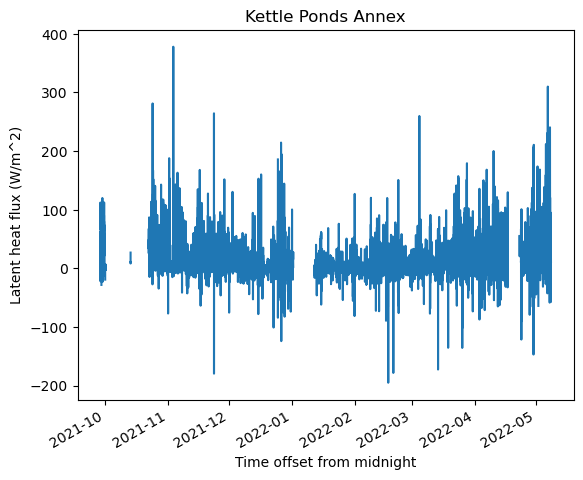

In [12]:
all_hl_data.plot()
plt.ylabel("Latent heat flux (W/m^2)")
plt.title('Kettle Ponds Annex')

In [13]:
splash_files_avp = glob.glob("/data2/elilouis/sublimationofsnow/asfs/avp/sledseb.asfs50.level2.0.10min.*.000000.nc")
Hl_ds_list = []
for f in splash_files_avp:
    Hl_ds_list.append(xr.open_dataset(f)['Hl'])
all_hl_data = xr.concat(Hl_ds_list, dim='time')

splash_avp_lhflux_ds = all_hl_data.resample(time='30Min').mean()
splash_avp_lhflux_ds = utils.modify_xarray_timezone(splash_avp_lhflux_ds, pytz.UTC, pytz.timezone("US/Mountain"))

Text(0.5, 1.0, 'Avery Picnic')

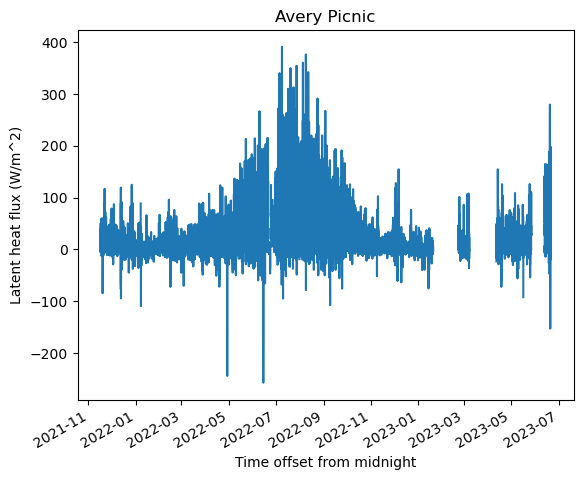

In [14]:
all_hl_data.plot()
plt.ylabel("Latent heat flux (W/m^2)")
plt.title('Avery Picnic')

## SAIL ECOR

In [15]:
ls '/data2/elilouis/sublimationofsnow/' | grep guc

guc30ecorM1.b1/
guc30ecorS3.b1/
gucdlfptM1.b1/
gucdlprofwind4newsM1.c1/
gucdlrhiM1.b1/
gucgndirtM1.b1/
gucgndrad60sM1.b1/
gucldM1.b1/
gucldS3.b1/
gucmetM1.b1/
gucsebsS3.b1/
gucsondewnpnM1.b1/
guctsiskycoverM1.b1/


In [16]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'

output_dir = '/data2/elilouis/sublimationofsnow/'

kp_sail_ecor_download_dir = os.path.join(output_dir, ecor_kp)
gothic_sail_ecor_download_dir = os.path.join(output_dir, ecor_gothic)

#### Download ECOR measurements

In [17]:
# act.discovery.download_data(
#     username,    token,    ecor_gothic,    
#     start_date_lastseason,
#     end_date,
#     output = os.path.join(output_dir, ecor_gothic)
# )
# act.discovery.download_data(
#     username,    token,    ecor_kp,    
#     start_date_lastseason,
#     end_date,
#     output = os.path.join(output_dir, ecor_kp)
# )

In [18]:
ecor_gothic_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(output_dir, ecor_gothic, '*.cdf'))
)
ecor_gothic_ds_thisseason = ecor_gothic_ds.sel(time = slice(start_date, end_date))
ecor_gothic_ds_lastseason = ecor_gothic_ds.sel(time = slice(start_date_lastseason, end_date_lastseason))
ecor_gothic_ds_thisseason = utils.modify_xarray_timezone(ecor_gothic_ds_thisseason, pytz.UTC, pytz.timezone("US/Mountain"))
ecor_gothic_ds_lastseason = utils.modify_xarray_timezone(ecor_gothic_ds_lastseason, pytz.UTC, pytz.timezone("US/Mountain"))
del ecor_gothic_ds

In [19]:
ecor_kps_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(output_dir, ecor_kp, '*.cdf'))
)
# CHANGE TIMEZONE
ecor_kps_ds_thisseason = ecor_kps_ds.sel(time = slice(start_date, end_date))
ecor_kps_ds_lastseason = ecor_kps_ds.sel(time = slice(start_date_lastseason, end_date_lastseason))
ecor_kps_ds_thisseason = utils.modify_xarray_timezone(ecor_kps_ds_thisseason, pytz.UTC, pytz.timezone("US/Mountain"))
ecor_kps_ds_lastseason = utils.modify_xarray_timezone(ecor_kps_ds_lastseason, pytz.UTC, pytz.timezone("US/Mountain"))
del ecor_kps_ds

# Remove LH flux outliers from 5min and 30min datasets

### Implement Vickers and Mahrt (1997) spike filtering

(text taken from the paper)
* The window moves one point at a time through the series. 
* Any point in the window that is more than 3.5 standard deviations from the window mean is considered a spike. 
* The point is replaced using linear interpolation between data points. 
* When four or more consecutive points are detected, they are not considered spikes and are not replaced. 
* The entire process is repeated until no more spikes are detected. 
* During the second pass, when the standard deviations may be smaller if spikes were replaced on the previous pass, the threshold for spike detection increases to 3.6 standard deviations and a like amount for each subsequent pass. 
* The record is hard flagged when the total number of spikes replaced exceeds 1% of the total number of data points.

In [20]:
# # Group 5minute data by hour and calculate turbulence statistics for each hour
# def remove_spike(series, std_factor = 2.2):
#     std = series.std()
#     mean = series.mean()
#     series_filtered = series.apply(lambda val: np.nan if 
#                                         (val < mean - std_factor*std) or (val > mean + std_factor * std) 
#                                     else    
#                                         val
#                                    )
#     return series_filtered

# def filtering_algorithm(series):
#     # Calculate initial number of nans
#     previous_num_nans = series['value'].isna().sum()
#     print(f"previous_num_nans: {previous_num_nans}")

#     # Identify spikes and make them nans
#     series = series.set_index('time')['value'].groupby(pd.Grouper(freq='60Min')).transform(remove_spike).reset_index()

#     # Calculate number of spikes that were detected
#     despiked_num_nans = series['value'].isna().sum()
#     spikes_detected = despiked_num_nans - previous_num_nans
#     print(f"spikes_detected: {spikes_detected}")

#     # initialize our check so that the while loop starts
#     previous_spikes_detected = spikes_detected + 1
#     while spikes_detected < previous_spikes_detected:
#         # Interpolate nans
#         series['value'] = series['value'].interpolate(limit=3).dropna()
        
#         # Calculate number of nans  after a round of spike-ID and interpolation
#         previous_num_nans = series['value'].isna().sum()
#         print(f"previous_num_nans: {previous_num_nans}")

#         # Again, identify spikes and make them nans
#         series = series.set_index('time')['value'].groupby(pd.Grouper(freq='60Min')).transform(remove_spike).reset_index()
#         # calculate number of detected spikes
#         despiked_num_nans = series['value'].isna().sum()
#         previous_spikes_detected = spikes_detected
#         spikes_detected = despiked_num_nans - previous_num_nans
#         print(f"previous_spikes_detected: {previous_spikes_detected}")
#         print(f"spikes_detected: {spikes_detected}")
#     return series

### Filter and inteprolate data

In [21]:
# src_2m_c = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__2m_c'"))
# src_3m_c = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__3m_c'"))
# src_5m_c = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__5m_c'"))
# src_10m_c = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__10m_c'"))
# src_15m_c = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__15m_c'"))
# src_20m_c = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__20m_c'"))

# src_1m_d = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__1m_d'"))
# src_3m_d = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__3m_d'"))
# src_10m_d = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__10m_d'"))

# src_1m_ue = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__1m_ue'"))
# src_3m_ue = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__3m_ue'"))
# src_10m_ue = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__10m_ue'"))

# src_1_uw = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__1m_uw'"))
# src_3_uw = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__3m_uw'"))
# src_10_uw = filtering_algorithm(tidy_df_5Min.query("variable == 'w_h2o__10m_uw'"))

### Assign data back to tidy df

In [22]:
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__2m_c',  'value'] = src_2m_c.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__3m_c',  'value'] = src_3m_c.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__5m_c',  'value'] = src_5m_c.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__10m_c',  'value'] = src_10m_c.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__15m_c',  'value'] = src_15m_c.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__20m_c',  'value'] = src_20m_c.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values

# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__1m_d',  'value'] = src_1m_d.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__3m_d',  'value'] = src_3m_d.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__10m_d',  'value'] = src_10m_d.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values

# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__1m_ue',  'value'] = src_1m_ue.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__3m_ue',  'value'] = src_3m_ue.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__10m_ue',  'value'] = src_10m_ue.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values

# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__1m_uw',  'value'] = src_1_uw.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__3m_uw',  'value'] = src_3_uw.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values
# tidy_df_30Min.loc[tidy_df_30Min.variable == 'w_h2o__10m_uw',  'value'] = src_10_uw.set_index('time').groupby(pd.Grouper(freq = '30Min')).mean()['value'].values

In [23]:
alt.Chart(
    tidy_df_30Min[tidy_df_30Min.measurement == 'w_h2o_']
).mark_line().transform_window(
    sort = [{'field':'time'}],
    frame = [None,0],
    cumulative_sublimation = 'sum(value)',
    groupby=['height', 'tower'],
).encode(
    x='time:T',
    # Plot the calculated field created by the transformation
    y=alt.Y('cumulative_sublimation:Q').scale(domain=[0,40], clamp=True),
    color=alt.Color('height:O').scale(scheme='rainbow'),
    facet='tower:N',
    tooltip='height'
)

alt.Chart(...)

## Simple IQR filter

In [24]:
def get_outlier_threshold(values, iqr_multiple = 5):
    q1, q3 = np.percentile(sorted(values), [25, 75])

    # compute IRQ
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (iqr_multiple * iqr)
    upper_bound = q3 + (iqr_multiple * iqr)
    return lower_bound, upper_bound

### SoS

In [25]:
measured_sublimation_variables = [ v for v in tidy_df_30Min.variable.unique() if v.startswith("w_h2o__") and 'predicted' not in v ]
measured_sublimation_variables

['w_h2o__10m_c',
 'w_h2o__10m_d',
 'w_h2o__10m_ue',
 'w_h2o__10m_uw',
 'w_h2o__15m_c',
 'w_h2o__1m_d',
 'w_h2o__1m_ue',
 'w_h2o__1m_uw',
 'w_h2o__20m_c',
 'w_h2o__2m_c',
 'w_h2o__3m_c',
 'w_h2o__3m_d',
 'w_h2o__3m_ue',
 'w_h2o__3m_uw',
 'w_h2o__5m_c']

In [26]:
for variable in measured_sublimation_variables:
    print(variable)
    filter = tidy_df_30Min.variable == variable
    lower_bound, upper_bound = get_outlier_threshold(
        tidy_df_30Min.loc[filter, 'value'].dropna().values
    )
    print(f"Bounds, 30Min: {(lower_bound, upper_bound)}")
    is_included = (tidy_df_30Min.loc[filter, 'value'] > lower_bound) & (tidy_df_30Min.loc[filter, 'value'] < upper_bound)
    tidy_df_30Min.loc[filter, 'value'] = tidy_df_30Min.loc[filter, 'value'].where(is_included)
    print(f"{is_included.value_counts()[False]} dropped of {len(is_included)}")

    filter = tidy_df_5Min.variable == variable
    lower_bound, upper_bound = get_outlier_threshold(
        tidy_df_5Min.loc[filter, 'value'].dropna().values
    )
    print(f"Bounds, 5Min: {(lower_bound, upper_bound)}")
    is_included = (tidy_df_5Min.loc[filter, 'value'] > lower_bound) & (tidy_df_5Min.loc[filter, 'value'] < upper_bound)
    tidy_df_5Min.loc[filter, 'value'] = tidy_df_5Min.loc[filter, 'value'].where(is_included)
    print(f"{is_included.value_counts()[False]} dropped of {len(is_included)}")
    print()

w_h2o__10m_c
Bounds, 30Min: (-0.025885360919346567, 0.03073745742221945)
650 dropped of 8114
Bounds, 5Min: (-0.02419667533831671, 0.02846866482286714)
4805 dropped of 48672

w_h2o__10m_d
Bounds, 30Min: (-0.022497242946277158, 0.02677243405120559)
857 dropped of 8114
Bounds, 5Min: (-0.02182209157763282, 0.02578639414787176)
6023 dropped of 48672

w_h2o__10m_ue
Bounds, 30Min: (-0.022428374923341227, 0.02659231392469034)
822 dropped of 8114
Bounds, 5Min: (-0.02210452815052122, 0.025924699613824487)
5920 dropped of 48672

w_h2o__10m_uw
Bounds, 30Min: (-0.024895064458178236, 0.029727370386960196)
948 dropped of 8114
Bounds, 5Min: (-0.023773782362695783, 0.028151238715508953)
6603 dropped of 48672

w_h2o__15m_c
Bounds, 30Min: (-0.018106606058249024, 0.021533642414349668)
486 dropped of 8114
Bounds, 5Min: (-0.01715985314513091, 0.020162658467597794)
3832 dropped of 48672

w_h2o__1m_d
Bounds, 30Min: (-0.013831025429302223, 0.016092329253751817)
1940 dropped of 8114
Bounds, 5Min: (-0.0143122423

In [27]:
alt.Chart(
    tidy_df_30Min[tidy_df_30Min.measurement == 'w_h2o_']
).mark_line().transform_window(
    sort = [{'field':'time'}],
    frame = [None,0],
    cumulative_sublimation = 'sum(value)',
    groupby=['height', 'tower'],
).encode(
    x='time:T',
    # Plot the calculated field created by the transformation
    y=alt.Y('cumulative_sublimation:Q').scale(domain=[0,40], clamp=True),
    color=alt.Color('height:O').scale(scheme='rainbow'),
    facet='tower:N',
    tooltip='height'
)

alt.Chart(...)

### ECOR

In [28]:
lower_bound, upper_bound = get_outlier_threshold(
    ecor_kps_ds_thisseason['cvar_wq'].dropna(dim='time').values
)
print((lower_bound, upper_bound))
ecor_kps_ds_thisseason['cvar_wq'] = ecor_kps_ds_thisseason['cvar_wq'].where(
        (ecor_kps_ds_thisseason['cvar_wq'] > lower_bound) & 
        (ecor_kps_ds_thisseason['cvar_wq'] < upper_bound)
    )

lower_bound, upper_bound = get_outlier_threshold(
    ecor_gothic_ds_thisseason['cvar_wq'].dropna(dim='time').values
)
print((lower_bound, upper_bound))
ecor_gothic_ds_thisseason['cvar_wq'] = ecor_gothic_ds_thisseason['cvar_wq'].where(
        (ecor_gothic_ds_thisseason['cvar_wq'] > lower_bound) & 
        (ecor_gothic_ds_thisseason['cvar_wq'] < upper_bound)
    )


lower_bound, upper_bound = get_outlier_threshold(
    ecor_kps_ds_lastseason['cvar_wq'].dropna(dim='time').values
)
print((lower_bound, upper_bound))
ecor_kps_ds_lastseason['cvar_wq'] = ecor_kps_ds_lastseason['cvar_wq'].where(
        (ecor_kps_ds_lastseason['cvar_wq'] > lower_bound) & 
        (ecor_kps_ds_lastseason['cvar_wq'] < upper_bound)
    )

lower_bound, upper_bound = get_outlier_threshold(
    ecor_gothic_ds_lastseason['cvar_wq'].dropna(dim='time').values
)
print((lower_bound, upper_bound))
ecor_gothic_ds_lastseason['cvar_wq'] = ecor_gothic_ds_lastseason['cvar_wq'].where(
        (ecor_gothic_ds_lastseason['cvar_wq'] > lower_bound) & 
        (ecor_gothic_ds_lastseason['cvar_wq'] < upper_bound)
    )

(-1.7951799975708127, 2.1027249968610704)
(-2.1024549901485443, 2.4344124868512154)
(-1.698460005223751, 1.99490000680089)
(-4.5839793993509375, 5.50509112936561)


# Calculate cumulative sublimation with daily mean latent heat fluxes

## SOS

### Create daily dataset

In [29]:
tidy_df_30Min['date'] = tidy_df_30Min['time'].dt.date

tidy_df_daily = tidy_df_30Min.drop(columns=['time']).groupby(
    ['date', 'tower', 'height', 'measurement', 'variable']
).mean().reset_index()

tidy_df_daily['time'] = pd.to_datetime(tidy_df_daily['date'])

tidy_df_daily = tidy_df_daily.drop(columns=['date'])

# remove days with only partial data
tidy_df_daily = tidy_df_daily[
    tidy_df_daily.time > tidy_df_daily.time.min()
][
    tidy_df_daily.time < tidy_df_daily.time.max()
]

/tmp/ipykernel_496/400594300.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df_daily = tidy_df_daily[


### Calculate cumulative sublimation

#### For measured sublimation

In [30]:
seconds_per_day = 60*60*24
seconds_per_30min = 60*30
seconds_per_5min = 60*5
for variable in measured_sublimation_variables:
    height = int(variable.split('_')[-2].split('m')[0])
    tower = variable.split('_')[-1]
    tidy_df_daily = tidy.tidy_df_add_variable(
        tidy_df_daily,
        np.cumsum(tidy_df_daily.query(f"variable == '{variable}'")['value']*seconds_per_day).values/metpy.constants.density_water.magnitude,
        f"cumulative_sub_measured_{height}m_{tower}",
        "Cumulative sublimation measured",  
        height,
        tower
    )
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,
        np.cumsum(tidy_df_30Min.query(f"variable == '{variable}'")['value']*seconds_per_30min).values/metpy.constants.density_water.magnitude,
        f"cumulative_sub_measured_{height}m_{tower}",
        "Cumulative sublimation measured",  
        height,
        tower
    )
    tidy_df_5Min = tidy.tidy_df_add_variable(
        tidy_df_5Min,
        np.cumsum(tidy_df_5Min.query(f"variable == '{variable}'")['value']*seconds_per_5min).values/metpy.constants.density_water.magnitude,
        f"cumulative_sub_measured_{height}m_{tower}",
        "Cumulative sublimation measured",  
        height,
        tower
    )



In [31]:
[v for v in tidy_df_30Min.variable.unique() if 'cumulative_sub_measured_' in v]

['cumulative_sub_measured_10m_c',
 'cumulative_sub_measured_10m_d',
 'cumulative_sub_measured_10m_ue',
 'cumulative_sub_measured_10m_uw',
 'cumulative_sub_measured_15m_c',
 'cumulative_sub_measured_1m_d',
 'cumulative_sub_measured_1m_ue',
 'cumulative_sub_measured_1m_uw',
 'cumulative_sub_measured_20m_c',
 'cumulative_sub_measured_2m_c',
 'cumulative_sub_measured_3m_c',
 'cumulative_sub_measured_3m_d',
 'cumulative_sub_measured_3m_ue',
 'cumulative_sub_measured_3m_uw',
 'cumulative_sub_measured_5m_c']

#### For modeled sublimation

In [ ]:
predicted_sublimation_variables = [ v for v in tidy_df_30Min.variable.unique() if v.startswith("w_h2o__") and 'predicted' in v ]
predicted_sublimation_variables             

In [ ]:
# these only exist in the 30 minute data
for variable in predicted_sublimation_variables:
    [basic_variable_name, extra_variable_info] = variable.split(' predicted')
    extra_variable_info_clean = extra_variable_info.replace('(', '').replace(')', '').replace(' ', '_')
    height = int(basic_variable_name.split('_')[-2].split('m')[0])
    tower = basic_variable_name.split('_')[-1]
    # print(f"cumulative_sub_modeled{extra_variable_info_clean}_{height}m_{tower}")
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,
        np.cumsum(tidy_df_30Min.query(f"variable == '{variable}'")['value']*60*30).values*1000/(1e6),
        f"cumulative_sub_modeled{extra_variable_info_clean}_{height}m_{tower}",
        "Cumulative sublimation modeled",  
        height,
        tower
    )

## ECOR

### Convert from mmol/m^3 to g/m^2

In [ ]:
for v in ecor_kps_ds_thisseason:
    print(ecor_kps_ds_thisseason[v].attrs['long_name'])

In [ ]:

# convert from mmol/m^3 to g/m^2
# 18.02 grams/mol
# conversion: (original / 1000) * 18.02
ecor_kps_df_thisseason = (ecor_kps_ds_thisseason['cvar_wq']*18.02/1000).to_dataframe().reset_index()
ecor_gothic_df_thisseason = (ecor_gothic_ds_thisseason['cvar_wq']*18.02/1000).to_dataframe().reset_index()

ecor_kps_df_lastseason = (ecor_kps_ds_lastseason['cvar_wq']*18.02/1000).to_dataframe().reset_index()
ecor_gothic_df_lastseason = (ecor_gothic_ds_lastseason['cvar_wq']*18.02/1000).to_dataframe().reset_index()

### Remove ECOR data to match time/extent of SoS data from 2022-23

In [ ]:
ecor_kps_df_thisseason = ecor_kps_df_thisseason[ecor_kps_df_thisseason['time'] > dt.datetime.strptime(start_date, '%Y%m%d')]
ecor_kps_df_thisseason = ecor_kps_df_thisseason[ecor_kps_df_thisseason['time'] < dt.datetime.strptime(end_date, '%Y%m%d')]

ecor_gothic_df_thisseason = ecor_gothic_df_thisseason[ecor_gothic_df_thisseason['time'] > dt.datetime.strptime(start_date, '%Y%m%d')]
ecor_gothic_df_thisseason = ecor_gothic_df_thisseason[ecor_gothic_df_thisseason['time'] < dt.datetime.strptime(end_date, '%Y%m%d')]

ecor_kps_df_lastseason = ecor_kps_df_lastseason[ecor_kps_df_lastseason['time'] > dt.datetime.strptime(start_date, '%Y%m%d').replace(year=2021)]
ecor_kps_df_lastseason = ecor_kps_df_lastseason[ecor_kps_df_lastseason['time'] < dt.datetime.strptime(end_date, '%Y%m%d').replace(year=2022)]

ecor_gothic_df_lastseason = ecor_gothic_df_lastseason[ecor_gothic_df_lastseason['time'] > dt.datetime.strptime(start_date, '%Y%m%d').replace(year=2021)]
ecor_gothic_df_lastseason = ecor_gothic_df_lastseason[ecor_gothic_df_lastseason['time'] < dt.datetime.strptime(end_date, '%Y%m%d').replace(year=2022)]

### Create daily datasets

In [ ]:
ecor_gothic_df_thisseason_daily = ecor_gothic_df_thisseason.set_index('time').resample('1440Min').mean().reset_index()
ecor_kps_df_thisseason_daily = ecor_kps_df_thisseason.set_index('time').resample('1440Min').mean().reset_index()
ecor_gothic_df_lastseason_daily = ecor_gothic_df_lastseason.set_index('time').resample('1440Min').mean().reset_index()
ecor_kps_df_lastseason_daily = ecor_kps_df_lastseason.set_index('time').resample('1440Min').mean().reset_index()

### Calculate cumulative sublimation

In [ ]:
ecor_gothic_df_thisseason_daily['Cumulative sublimation (mm)'] = np.cumsum(
    (ecor_gothic_df_thisseason_daily['cvar_wq'].fillna(0)*60*60*24).values*1000/(1e6)
)
ecor_kps_df_thisseason_daily['Cumulative sublimation (mm)'] = np.cumsum(
    (ecor_kps_df_thisseason_daily['cvar_wq'].fillna(0)*60*60*24).values*1000/(1e6)
)

ecor_gothic_df_lastseason_daily['Cumulative sublimation (mm)'] = np.cumsum(
    (ecor_gothic_df_lastseason_daily['cvar_wq'].fillna(0)*60*60*24).values*1000/(1e6)
)
ecor_kps_df_lastseason_daily['Cumulative sublimation (mm)'] = np.cumsum(
    (ecor_kps_df_lastseason_daily['cvar_wq'].fillna(0)*60*60*24).values*1000/(1e6)
)

# Plot all Cumul. Sublimation Calculations

In [ ]:
src = tidy_df_30Min.query("measurement == 'Cumulative sublimation measured'")
src.value = src.groupby(['measurement', 'variable', 'height', 'tower']).value.ffill()
src = src[src.time < "2023-05-10"]
alt.Chart(
    src
).mark_errorband(extent = 'stdev', color='#2ca02c').encode(
    x = 'time:T',
    y = 'value:Q'
).properties() + \
alt.Chart(
    src[src.time < "2023-05-11"].query("variable == 'cumulative_sub_measured_3m_c'")
).mark_line(color='#2ca02c').encode(
    x = 'time:T',
    y = 'value:Q'
)

In [ ]:
alt.Chart(
    src[~ src.variable.isin([
        'cumulative_sub_measured_10m_c', 
        'cumulative_sub_measured_1m_uw', 
        'cumulative_sub_measured_3m_ue',
        'cumulative_sub_measured_3m_d',
        'cumulative_sub_measured_1m_d'
    ])]
).mark_line(
    # strokeWidth=1.0, color='#2ca02c', opacity=0.5
).encode(
    x = 'time:T',
    y = alt.Y('value:Q').title("Cumulative sublimation (mm SWE)"),
    color=alt.Color('height:O').title("height (m)"),
    detail = "variable:O",
    tooltip = 'variable:O'
).display(renderer='svg')

In [ ]:
measured_sub_chart = alt.Chart(
    src[~ src.variable.isin([
        'cumulative_sub_measured_10m_c', 
        'cumulative_sub_measured_1m_uw', 
        'cumulative_sub_measured_3m_ue',
        'cumulative_sub_measured_3m_d',
        'cumulative_sub_measured_1m_d'
    ])]
).mark_line(
    strokeWidth=1.0, color='#2ca02c', opacity=0.5
).encode(
    x = 'time:T',
    y = alt.Y('value:Q').title("Cumulative sublimation (mm SWE)"),
    detail = "variable:O",
    tooltip = 'variable:O'
)

measured_sub_chart

In [ ]:
src = tidy_df_30Min.query("measurement == 'Cumulative sublimation modeled'")
src.value = src.groupby(['measurement', 'variable', 'height', 'tower']).value.ffill()
src = src[src.time < "2023-05-10"]
simple_modeled_sub_chart = alt.Chart(
    src[src.variable.str.contains('Penman')]
).mark_line().encode(
    x = 'time:T',
    y = alt.Y('value:Q').title("Cumulative sublimation (mm SWE)"),
    color = 'variable:N'
)
simple_modeled_sub_chart.configure_legend(labelLimit = 2000).display(renderer='svg')

In [ ]:
(measured_sub_chart + simple_modeled_sub_chart).configure_axis(grid=False).configure_legend(labelLimit = 2000).display(renderer='svg')

In [ ]:
src = model_df_cumsum_daily.query("surface_measurement != 'Tsurf_d'")
src = src.query("surface_measurement != 'Td_3m_c'")
src = src[src.time < "2023-05-11"]
src = src.dropna().query("z0 <= 0.001")
most_modeled_sub_chart = alt.Chart(
    src
).mark_area(color='grey', opacity=0.1).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q").title("Cumulative sublimation (mm SWE)"),
    alt.Y2("max(latent heat flux (mm)):Q").title("Cumulative sublimation (mm SWE)"),
)
most_modeled_sub_chart

In [ ]:
src = model_df_cumsum_daily.query("surface_measurement != 'Tsurf_d'")
src = src.query("surface_measurement != 'Td_3m_c'")
src = src[src.time < "2023-05-11"]
src = src.dropna().query("z0 <= 0.001")
most_modeled_sub_chart_lines = alt.Chart(
    src
).mark_line(strokeWidth=0.25, color='grey', opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm):Q").title("Cumulative sublimation (mm SWE)"),
    detail = 'config'
)
most_modeled_sub_chart + most_modeled_sub_chart_lines

In [ ]:
ecor_gothic_and_kps_df_thisseason_daily = ecor_gothic_df_thisseason_daily.copy()
ecor_gothic_and_kps_df_thisseason_daily['Gothic'] = ecor_gothic_and_kps_df_thisseason_daily['Cumulative sublimation (mm)']
ecor_gothic_and_kps_df_thisseason_daily['Kettle Ponds'] = ecor_kps_df_thisseason_daily['Cumulative sublimation (mm)']
ecor_gothic_and_kps_df_thisseason_daily

In [ ]:
sailsail_sub_chart = alt.Chart(ecor_gothic_and_kps_df_thisseason_daily).transform_fold([   
    'Gothic',
    'Kettle Ponds'
]).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("key:N").scale(domain = ['Gothic', 'Kettle Ponds'], range = ['#d62728', '#9467bd'])
)
sailsail_sub_chart

In [ ]:
(most_modeled_sub_chart + measured_sub_chart
#   + simple_modeled_sub_chart
).configure_axis(grid=False).configure_legend(labelLimit = 2000).display(renderer='svg')

In [ ]:
(sailsail_sub_chart + most_modeled_sub_chart_lines + measured_sub_chart).resolve_scale(
    color = 'independent'
).configure_axis(grid=False).configure_legend(labelLimit = 2000).display(renderer='svg')

In [ ]:
(sailsail_sub_chart + most_modeled_sub_chart + measured_sub_chart + simple_modeled_sub_chart).resolve_scale(
    color = 'independent'
).configure_axis(grid=False).configure_legend(labelLimit = 2000).display(renderer='svg')

# Plot time series from a few days and many datasets

In [ ]:
alt.Chart(ecor_kps_df_thisseason).mark_tick().encode(
    alt.X("time:T")
).properties(width = 800) & alt.Chart(ecor_gothic_df_thisseason).mark_tick().encode(
    alt.X("time:T")
).properties(width = 800)

In [ ]:
january_case_study_df = pd.DataFrame({
    "Gothic, SAIL ECOR": ecor_gothic_df_thisseason.set_index("time").loc["2023-01-19": "2023-01-19"]['cvar_wq'],
    "Kettle Ponds, SAIL ECOR": ecor_kps_df_thisseason.set_index("time").loc["2023-01-19": "2023-01-19"]['cvar_wq'],
    "Kettle Ponds, SOS": tidy_df_30Min.set_index("time").loc["2023-01-19": "2023-01-19"].query("variable == 'w_h2o__3m_c'")['value'],
    'Avery Picnic, SPLASH': splash_avp_lhflux_ds.to_dataframe().loc["2023-01-19": "2023-01-19"]['Hl']/2838
    
})
april_case_study_df = pd.DataFrame({
    "Gothic, SAIL ECOR": ecor_gothic_df_thisseason.set_index("time").loc["2023-04-20": "2023-04-20"]['cvar_wq'],
    "Kettle Ponds, SAIL ECOR": ecor_kps_df_thisseason.set_index("time").loc["2023-04-20": "2023-04-20"]['cvar_wq'],
    "Kettle Ponds, SOS": tidy_df_30Min.set_index("time").loc["2023-04-20": "2023-04-20"].query("variable == 'w_h2o__3m_c'")['value'],
    'Avery Picnic, SPLASH': splash_avp_lhflux_ds.to_dataframe().loc["2023-04-20": "2023-04-20"]['Hl']/2838
})

In [ ]:
# (
# alt.Chart(src).mark_line().encode(
#     alt.X("time:T"),
#     alt.Y("latent heat flux:Q").title("Latent heat flux (g/m^2/s)").scale(
#         domain = [-0.006, 0.006]
#     ),
#     alt.Color("surface_measurement:N")
# )+ \
# alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
#     alt.X("time:T"),
#     alt.Y("value:Q")
# )).properties(width = 300, height = 150).configure_legend(orient='top').display(renderer = 'svg')

In [ ]:
((alt.Chart(january_case_study_df.reset_index().iloc[1:]).transform_fold([
    # "Gothic, SAIL ECOR",
    # "Kettle Ponds, SAIL ECOR",
    "Kettle Ponds, SOS",
    # 'Avery Picnic, SPLASH'
]).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-0.006, 0.006], clamp=True).title("Latent heat flux (g/m^2/s)"),
)).properties(width = 300, height = 150) +\
(alt.Chart(january_case_study_df.reset_index()).transform_fold([
    "Gothic, SAIL ECOR",
    "Kettle Ponds, SAIL ECOR",
    'Avery Picnic, SPLASH'
]).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-0.006, 0.006], clamp=True).title("Latent heat flux (g/m^2/s)"),
    alt.Color("key:N").title("Measurement").scale(
        domain = [
            "Gothic, SAIL ECOR",
        "Kettle Ponds, SAIL ECOR",
        'Avery Picnic, SPLASH'],
        range = ['#2ca02c', '#d62728', '#9467bd']
    )
)).properties(width = 300, height = 150)).display(renderer='svg')

In [ ]:
((alt.Chart(january_case_study_df.reset_index()).transform_fold([
    "Gothic, SAIL ECOR",
    "Kettle Ponds, SAIL ECOR",
    "Kettle Ponds, SOS",
    'Avery Picnic, SPLASH'
]).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-0.006, 0.006], clamp=True).title("Latent heat flux (g/m^2/s)"),
    alt.Color("key:N").title("Measurement")
)).properties(width = 300, height = 150) & \
(alt.Chart(april_case_study_df.reset_index()).transform_fold([
    "Gothic, SAIL ECOR",
    "Kettle Ponds, SAIL ECOR",
    "Kettle Ponds, SOS",
    'Avery Picnic, SPLASH'
]).mark_line().encode(
    alt.X("hoursminutes(time):T"),
    alt.Y("value:Q").scale().title("Latent heat flux (g/m^2/s)"),
    alt.Color("key:N").title("Measurement")
)).properties(width = 300, height = 150)).resolve_scale(y='independent').display(renderer='svg')

In [ ]:

february_case_study_df = pd.DataFrame({
    "Gothic, SAIL ECOR": ecor_gothic_df_thisseason.set_index("time").loc["2023-02-01": "2023-02-01"]['cvar_wq'],
    "Kettle Ponds, SAIL ECOR": ecor_kps_df_thisseason.set_index("time").loc["2023-02-01": "2023-02-01"]['cvar_wq'],
    "Kettle Ponds, SOS": tidy_df_30Min.set_index("time").loc["2023-02-01": "2023-02-01"].query("variable == 'w_h2o__3m_c'")['value']
})
march_case_study_df = pd.DataFrame({
    "Gothic, SAIL ECOR": ecor_gothic_df_thisseason.set_index("time").loc["2023-03-28": "2023-03-28"]['cvar_wq'],
    "Kettle Ponds, SAIL ECOR": ecor_kps_df_thisseason.set_index("time").loc["2023-03-28": "2023-03-28"]['cvar_wq'],
    "Kettle Ponds, SOS": tidy_df_30Min.set_index("time").loc["2023-03-28": "2023-03-28"].query("variable == 'w_h2o__3m_c'")['value']
})

In [ ]:
(alt.Chart(february_case_study_df.reset_index()).transform_fold([
    "Gothic, SAIL ECOR",
    "Kettle Ponds, SAIL ECOR",
    "Kettle Ponds, SOS"
]).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-0.03, 0.03]).title("Latent heat flux (g/m^2/s)"),
    alt.Color("key:N").title("Measurement")
)).resolve_scale(y='independent').properties(width = 360, height = 240).configure_legend(orient='top').display(renderer='svg')

In [ ]:
(alt.Chart(march_case_study_df.reset_index()).transform_fold([
    "Gothic, SAIL ECOR",
    "Kettle Ponds, SAIL ECOR",
    "Kettle Ponds, SOS"
]).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-0.03, 0.03]).title("Latent heat flux (g/m^2/s)"),
    alt.Color("key:N").title("Measurement")
)).resolve_scale(y='independent').properties(width = 360, height = 240).configure_legend(orient='top').display(renderer='svg')

# Save daily data

In [ ]:
tidy_df_daily.to_parquet(tidy_daily_dataset_output_fn)

In [ ]:

tidy_df_30Min_calm = tidy_df_30Min[tidy_df_30Min.time.isin(
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time.unique()
)]
tidy_df_30Min_blowing = tidy_df_30Min[tidy_df_30Min.time.isin(
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time.unique()
)]

# Compare multiple cumulative sublimation estimates

In [ ]:
sos_swe_chart_src = tidy_df_daily.query(
        "measurement == 'SWE'"
    ).query("tower == 'c'").dropna()

sos_swe_chart = alt.Chart(
    sos_swe_chart_src    
).mark_line(opacity=0.4, strokeDash=[1,2], color='black').encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Snow Pillow SWE (mm)').axis(offset=50),
)
sos_swe_chart

In [ ]:
sos_sublimation_src = tidy_df_30Min[tidy_df_30Min.measurement.isin([
    'Cumulative sublimation measured',
    'Cumulative sublimation modeled'
])]

sos_sublimation_chart = alt.Chart(
    sos_sublimation_src    
).mark_line(color='black').encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Cumulative sublimation (mm)'),
    alt.Color("variable:N"),
    alt.StrokeDash("measurement:N")
)
sos_sublimation_chart

In [ ]:
sos_sublimation_src = tidy_df_30Min[tidy_df_30Min.variable.isin([
    'cumulative_sub_measured_3m_c',
    'cumulative_sub_modeled_turbpy_webb_noahmp_3m_c'
])]

sos_sublimation_chart = alt.Chart(
    sos_sublimation_src    
).mark_line(color='black').encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Cumulative sublimation (mm)'),
    alt.StrokeDash("variable:N", legend=None)
)
sos_sublimation_chart

# Make additional calculations

To Do/Add:

* water flux into soil
* SWE from snow pillows + overlaid snow pit data

# Calculate daily sublimation

$$ \frac{g}{m^2 * s} * \frac{1800 s}{measurement} * \frac{.001 kg}{g} * \frac{1 m^3}{1000 kg} * \frac{1000 mm }{m}$$

$$ \frac{m}{s} * 1800 * .001 * (1 / 1000) * (1000)$$

In [4]:
daily_sub_by_blowingsnow_src = tidy_df_30Min[
    (tidy_df_30Min.time > start_date) & (tidy_df_30Min.time < end_date) # remove days with partial data
    & tidy_df_30Min.variable.isin(['w_h2o__3m_c', 'SF_avg_1m_ue', 'SF_avg_2m_ue'])
].pivot_table(
    values = 'value',
    index = 'time',
    columns = 'variable'
)
daily_sub_by_blowingsnow_src['SF_avg_max_ue'] = daily_sub_by_blowingsnow_src[['SF_avg_1m_ue', 'SF_avg_2m_ue']].max(axis=1)
daily_sub_by_blowingsnow_src['blowing snow'] = daily_sub_by_blowingsnow_src['SF_avg_max_ue'] > 0
daily_sub_by_blowingsnow_src['Sublimation (mm)'] = daily_sub_by_blowingsnow_src['w_h2o__3m_c'] *60*30*0.001 # calculate daily sublimation
daily_sub_by_blowingsnow_src = daily_sub_by_blowingsnow_src.groupby([pd.Grouper(freq='1440Min'), 'blowing snow']).sum()
daily_sub_by_blowingsnow_src = daily_sub_by_blowingsnow_src.reset_index()
daily_sub_by_blowingsnow_src

variable,time,blowing snow,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c,SF_avg_max_ue,Sublimation (mm)
0,2022-11-30,False,0.000000,0.000000,-0.027082,0.000000,-0.048747
1,2022-12-01,False,0.000000,0.000000,0.095618,0.000000,0.172112
2,2022-12-02,False,0.000000,0.000000,0.018089,0.000000,0.032560
3,2022-12-02,True,3.015333,3.996667,0.208166,4.093667,0.374698
4,2022-12-03,False,0.000000,0.000000,0.006676,0.000000,0.012017
...,...,...,...,...,...,...,...
270,2023-05-13,False,0.000000,0.000000,0.107166,0.000000,0.192899
271,2023-05-13,True,0.003333,0.006667,0.007872,0.006667,0.014169
272,2023-05-14,False,0.000000,0.000000,0.256507,0.000000,0.461713
273,2023-05-15,False,0.000000,0.000000,0.535407,0.000000,0.963733


In [9]:
daily_sublimation_chart = alt.Chart(daily_sub_by_blowingsnow_src[
    daily_sub_by_blowingsnow_src.time < "2023-05-11"
]).mark_bar(width=2).encode(
    alt.X("time:T", title=None),
    alt.Y("Sublimation (mm):Q").title("Daily sublimation (mm)"), 
    alt.Color("blowing snow:N"),
    tooltip='time:T'
).properties(height = 100)
daily_sublimation_chart.configure_axis(grid=False).display(renderer='svg')

alt.Chart(...)

Stability regime plots, using -0.25 and 0.25 to distinguish Ri number

In [ ]:
def ri_to_stability_regime(x):
    if np.isnan(x):
        return None
    elif x < -0.25:
        return "unstable"
    elif x >= -0.25 and x <= 0.25:
        return "neutral"
    elif x > 0.25:
        return "stable"
    else:
        raise ValueError("what?")

src = tidy_df_5Min.query("variable == 'Ri_3m_c'")
# src = src[src.time.dt.hour.isin([10,11,12,13,14,15])]
src['date'] = src.time.dt.date
src = src.groupby('date').median().reset_index()
src['stability regime'] = src['value'].apply(ri_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable'])
).properties(width = 800)
stability_regime_chart

In [ ]:
src = tidy_df_5Min.query("variable == 'Ri_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).median().reset_index()
src['stability regime'] = src['value'].apply(ri_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable']),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 800)
stability_regime_chart

Stability regime plots, using -0.01 and 0.01 to distinguish ${d\theta}/{dz}$

In [ ]:
def temp_gradient_to_stability_regime(x):
    if np.isnan(x):
        return None
    elif x < -0.01:
        return "unstable"
    elif x >= -0.01 and x <= 0.01:
        return "neutral"
    elif x > 0.01:
        return "stable"
    else:
        raise ValueError("what?")
src = tidy_df_5Min.query("variable == 'temp_gradient_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).median().reset_index()
src['stability regime'] = src['value'].apply(temp_gradient_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable']),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 800)
stability_regime_chart

Same as above but we find the minimum temp gradient during the night and day hour to reveal how frequently unstable conditions did occur

In [ ]:
src = tidy_df_5Min.query("variable == 'temp_gradient_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).min().reset_index()
src['stability regime'] = src['value'].apply(temp_gradient_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable']),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 800)
stability_regime_chart

In [ ]:
ri_chart = alt.Chart(
    tidy_df_30Min.query("variable == 'Ri_3m_c'")
).transform_window(
    rolling_avg = "median(value)",
    frame = [-3, 3]
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("rolling_avg:Q").title('Ri')
)

temp_chart = alt.Chart(
    tidy_df_daily.query("variable == 'T_3m_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Mean daily temperature (˚C)')
)

surf_temp_chart = alt.Chart(
    tidy_df_daily.query("variable == 'Tsurf_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)').axis(labels=False, ticks=False),
    alt.Y("value:Q").title('Mean daily surface temperature (˚C)')
)

surf_and_air_temp_chart = alt.Chart(
    tidy_df_daily[tidy_df_daily.variable.isin(['T_3m_c', 'Tsurf_c'])]
).mark_line().encode(
    alt.X("time:T", title=None).axis(labels=False, ticks=False),
    alt.Y("value:Q").title("Temperature (˚C)"),
    alt.StrokeDash("measurement:N")
)

spd_chart = alt.Chart(
    tidy_df_daily.query("variable == 'spd_3m_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Mean daily wind speed (m/s)')
)

netrad_chart = alt.Chart(
    tidy_df_daily.query("variable == 'Rnet_9m_d'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Net radiation (W/m^2)').axis(orient='right')
)

swrad_chart = alt.Chart(
    tidy_df_30Min.query("variable == 'Rsw_in_9m_d'")
).mark_line(opacity=0.3).encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title(['Incoming SW', 'radiation (W/m^2)']).axis(offset=50, orient='right').scale(domain=[-1000,1000])
)

soil_moisture_chart = alt.Chart(
    tidy_df_daily[tidy_df_daily.variable == 'Qsoil_d']
).mark_line(color='orange').encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Soil moisture").axis(orient='left'),
)

q_grad_chart = alt.Chart(
    tidy_df_daily.query("variable == 'q_gradient_3m_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Vapor pressure deficit (1/m)')
)

blowing_snow_flux_chart = alt.Chart(
    tidy_df_30Min[tidy_df_30Min.measurement == 'snow flux']
).transform_filter(
    alt.datum.value > 0
).transform_window(
    rolling_avg = "median(value)",
    frame = [-3, 3]
).mark_circle(size=20).encode(
    alt.X("time:T", title=None).axis(labels=False, ticks=False),
    alt.Y("rolling_avg:Q").title("Blowing snow flux (g/m^2/s)").scale(type='log'),
    alt.Color("height:N")
).properties(width=800)

In [ ]:
swe_dailysub_and_cumsub_chart = (
    daily_sublimation_chart + 
    (sos_sublimation_chart + 
    sos_swe_chart).resolve_scale(y='independent')
).resolve_scale(y='independent', color='independent').properties(width=800, height = 200)

zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule().encode(alt.Y('y').axis(None))

net_rad_and_soil_moisture_chart = (
    swrad_chart + 
    netrad_chart + 
    soil_moisture_chart
).resolve_scale(y='independent')

figure = (
    stability_regime_chart &
    swe_dailysub_and_cumsub_chart &
    blowing_snow_flux_chart.properties(height = 100)
    # surf_and_air_temp_chart.properties(height = 100) &
    # net_rad_and_soil_moisture_chart.properties(height = 100) &
    # netrad_chart.properties(height = 100) &
    # q_grad_chart.properties(height = 100)
    
    # soil_moisture_chart.properties(height = 100) &
    # temp_chart.properties(height = 100) &
    # surf_temp_chart.properties(height = 100) &
    # spd_chart.properties(height = 100) &
    # netrad_chart.properties(height = 100)
).resolve_scale(x='shared', color='independent', strokeDash='independent').configure_legend(orient='left').configure_concat(spacing=0)

figure


## Calculate seasonal estimates of max SWE and cumulative sublimation

In [ ]:
# Seasonal Max SWE Estimate
tidy_df_30Min.query(
        "measurement == 'SWE'"
).query("tower == 'c'").dropna().value.max()

In [ ]:
# Cumulative sublimation EC
tidy_df_30Min.query(
    "measurement == 'Cumulative sublimation measured'"
).query(
    "height == 3"
).query(
    "tower == 'c'"
).value.dropna().max()

In [ ]:
tidy_df_30Min[
        tidy_df_30Min.variable.isin([
            'cumulative_sub_modeled_turbpy_webb_noahmp_3m_c',
            'cumulative_sub_modeled_3m_c',
        ])
].groupby("variable").value.max()

Find day and value of max SWE by tower

In [ ]:
display(sos_sublimation_src.query("tower == 'c'").sort_values('value', ascending=False).head(1))
display(sos_sublimation_src.query("tower == 'd'").sort_values('value', ascending=False).head(1))
display(sos_sublimation_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1))
display(sos_sublimation_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1))

In [ ]:
display(sos_swe_chart_src.query("tower == 'c'").sort_values('value', ascending=False).head(1))
display(sos_swe_chart_src.query("tower == 'd'").sort_values('value', ascending=False).head(1))
display(sos_swe_chart_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1))
display(sos_swe_chart_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1))

In [ ]:
print(100 *
    list(sos_sublimation_src.query("tower == 'c'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'c'").sort_values('value', ascending=False).head(1).value)[0]
)
print(100 *
    list(sos_sublimation_src.query("tower == 'd'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'd'").sort_values('value', ascending=False).head(1).value)[0]
)
print(100 *
    list(sos_sublimation_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1).value)[0]
)
print(100 *
    list(sos_sublimation_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1).value)[0]
)

# Find case study dates:
1. Calculate 3-consecutive-day average sublimation rate
2. Find largest value in each month (excluding May)
4. Find smallest value in each month (excluding May)

In [ ]:
local_src.set_index('time').loc[:'2023-04-09'].rolling(window=3, center=True).sum().sort_values('value', ascending=False).head(50)

# highest, first appearance from each month excluding May:
#   12/22
#   03/06
#   04/03
#   02/20

In [ ]:
local_src[['value', 'time']].set_index('time').rolling(window=3, center=True).sum().sort_values('value', ascending=True).head(50)

# lowest, first appearance from each month excluding May:
#   01/07 (negative)
#   12/10 (negative)
#   02/02 (negative)
#   02/12 (positive)
#   12/17 (positive)
#   01/13 (positive)

# Look at Turbulence at different sites

In [ ]:
sos_tke_src = tidy_df_30Min.query(
    "measurement == 'turbulent kinetic energy'"
).query("tower == 'c'")
sos_tke_src['EC System'] = sos_tke_src.apply(lambda row: f"KPS, SOS, tower {row.tower}, {row.height}m", axis=1)

In [ ]:
alt.Chart(sos_tke_src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("EC System:N")
).properties(width=800)

In [ ]:
ecor_gothic_ds_thisseason['TKE'] = 0.5*(ecor_gothic_ds_thisseason['var_u'] + ecor_gothic_ds_thisseason['var_v'] + ecor_gothic_ds_thisseason['var_w'])
ecor_kps_ds_thisseason['TKE'] = 0.5*(ecor_kps_ds_thisseason['var_u'] + ecor_kps_ds_thisseason['var_v'] + ecor_kps_ds_thisseason['var_w'])

In [ ]:
ecor_gothic_ds_thisseason_tke_df = ecor_gothic_ds_thisseason['TKE'].to_dataframe().reset_index().rename(columns={'TKE': 'value'})
ecor_kps_ds_thisseason_tke_df = ecor_kps_ds_thisseason['TKE'].to_dataframe().reset_index().rename(columns={'TKE': 'value'})

ecor_gothic_ds_thisseason_tke_df['EC System'] = 'SAIL, Gothic'
ecor_kps_ds_thisseason_tke_df['EC System']  = 'SAIL, KPS'

In [ ]:
tke_src = pd.concat([
    ecor_gothic_ds_thisseason_tke_df,
    ecor_kps_ds_thisseason_tke_df,
    sos_tke_src.query("tower == 'c'")[['time', 'EC System', 'value']]
])

In [ ]:
tke_src = tke_src[tke_src['EC System'].isin([
    'SAIL, Gothic', 
    'SAIL, KPS',
    'KPS, SOS, tower c, 2.0m',
    'KPS, SOS, tower c, 3.0m',
    'KPS, SOS, tower c, 20.0m',
])]

In [ ]:
tke_boxplot = alt.Chart(tke_src).mark_boxplot(size=40, outliers=False).encode(
    alt.X("EC System:N").axis(labelAngle=30),
    alt.Y("value:Q").title("TKE"),
    # alt.Color("EC System:N")
).properties(width = 300)

In [ ]:
tke_boxplot.properties(title=['Distribution of TKE measurements, Winter 2022-23,', 'for different campaigns'])

In [ ]:
tke_timeseries = alt.Chart(tke_src).transform_window(
    rolling_mean = 'mean(value)',
    frame = [-20, 20]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("rolling_mean:Q").title("TKE"),
    alt.Color("EC System:N")
).properties(width=800)

In [ ]:
tke_timeseries | tke_boxplot